In [68]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="This documment is written in a Jupyter notebook and the code used to produce these analyses has been hidden for ease of reading.  
To make the code visiable click here"></form>''')

### Estimating Soil Wat model parameters from basic principals

The Soil Wat model in APSIM uses some coarse and abstract parameters to represent soil water processes which are difficult to estimate.  The two most problimatic parameters are kl (the proportion of plant available water that a crop can extract from a given layer in a day) and swcon (the proportion of mobile water that will drain from a given layer in a day).  The data needed to obtain these parameter values dirrectly is usually absent so they are guessed.  

As an alternative we have run a model fitting exercise.  APSIM was run using SWIM which is a full Richards equation soil water model to simulate the experimental conditions in which kl and swcon would normally be assessed.  For kl a simulated wheat crop was established and water was withheld following full canopy to produce dry down patterns that and exponential was fitted to.  For swcon a saturating event was simulated followed by a dry period to give drainage patterns.  18 monolithic soils were used in each simulation representing a cross section of function horizions from New Zealand soils.  Exponentials were then fitted by eye.

In [69]:
#Bring in the python data that we need for the analysis
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
#List the soils to deal with 
Soils = ['Awatere19','Ayreburn17','Dannevirke39','Dannevirke40','Fork8','Glasnevin13',
        'Mandamus32','Mataikona30','Oronoko128','Oronoko129','Otorohanga57','Rangitata67',
        'Taupo97','TeToka8','Turangi40','Waikuku27','Wakanui_46']

#Read in the data for each soil and join into dataframe

Count = 0
for Soil in Soils:
    path = 'C:\GitHubRepos\MVI\RA1.4\SmapToApsim\kl_' + Soil + '.csv'
    OneSoilData = pd.read_csv(path,
                              skiprows =[0,1,3],
                              parse_dates=True, #tell the function to parse date columns to datetime formats
                              dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                              index_col = 0)
    OneSoilData['Soil'] = Soil
    if Count == 0:
        Data = OneSoilData
    else:
        Data = Data.append(OneSoilData)
    Count+=1

#Give columns better names
Data.columns = ['rain','es','sw22','sw34','sw46','sw58','sw71','cover_green','root_depth','rlv22',
                 'rlv34','rlv46','rlv58','rlv71','ep','pet_total','irrigation','dul22','dul34',
                 'dul46','dul58','dul71','ll1522','ll1534','ll1546','ll1558','ll1571','Unnamed','Soil']

Data.index = Data.index.to_datetime(dayfirst=False)
#Data.set_index('Soil', append = True, drop=False, inplace=True)
#Data.sort_index()
Data['FPAWC'] = (Data['sw22']-Data['ll1522'])/(Data['dul22']-Data['ll1522'])
FPAWC = Data.pivot_table(values='FPAWC',index = Data.index, columns='Soil' )

##kl analysis
The blue circles are simulate water contents represented as the fraction of plant available water (FPAW) in the soil layer from 22-34 cm depth [FPAW = (sw-ll15)/(dul-ll15)].  The green lines are the fitted values and the red lines are a break point where the water extraction patterns estimated by SWIM where no longer exponential and the Soilwat model could not be fitted to.  In most cases this corresponds to a reduction in crop LAI due to water stress reducing water uptake demand and slowing extraction rates. 

The decay rate of the exponentials fitted to each soil are shown in the graph and table below.

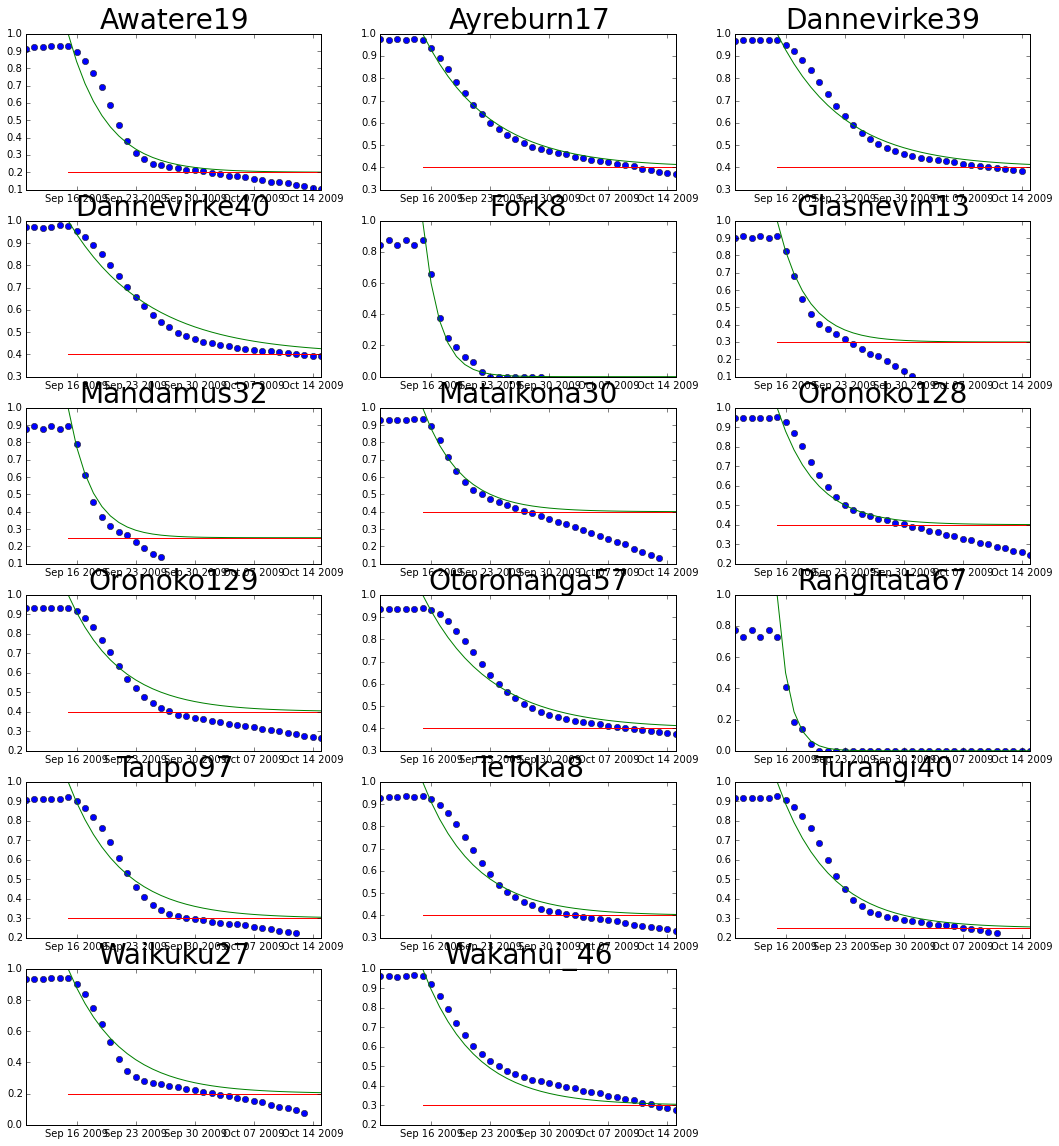

In [71]:
Fig = plt.figure(figsize=(18, 100))

def MakePlot(Position, Soil, kl,CoverLim):
        Fig.add_subplot(30,3,Position)
        plt.title(Soil, fontsize=28)
        plt.plot(FPAWC.ix['2009-09-10':'2009-10-15',Soil].index,
                 FPAWC.ix['2009-09-10':'2009-10-15',Soil],
                 'o')
        x = FPAWC.ix['2009-09-15':'2009-10-15'].index
        y = []
        b = []
        y.append(1)
        b.append(CoverLim)
        for z in range(FPAWC.ix['2009-09-15':'2009-10-15'].index.size-1):
            y.append(y[z] - (y[z]-CoverLim)*kl) 
            b.append(CoverLim)
        plt.plot(x,y)
        plt.plot(x,b)

kl =       [0.2,0.12,0.12,0.1,0.4,0.25,0.3,0.2,0.2,0.15,0.12,0.5,0.15,0.15,0.15,0.15,0.15]
CoverLim = [0.2,0.40,0.40,0.4,0.0,0.30,0.25,0.4,0.4,0.4,0.4,0,0.3,0.4,0.25,0.2,0.3]
Position = 1
for Soil in Soils:
    MakePlot(Position, Soil, kl[Position-1], CoverLim[Position-1])
    Position +=1

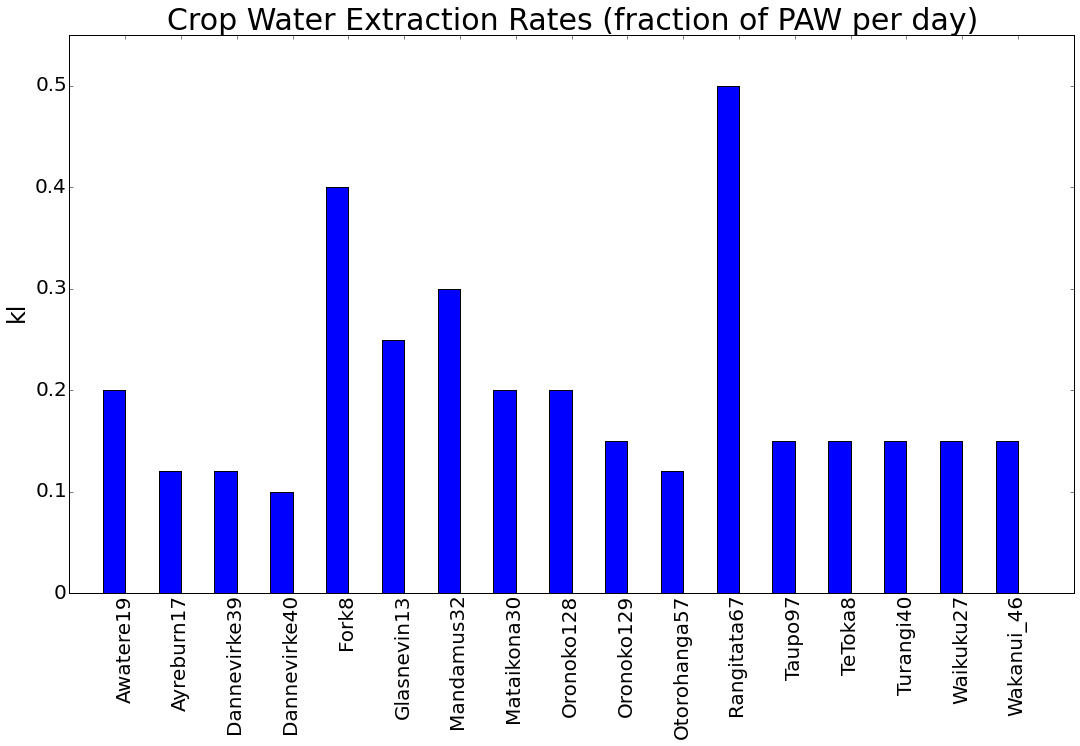

In [72]:
width = 0.4
ind = np.arange(17) - width
fig, ax = plt.subplots(figsize = (18,10))
ax.bar(ind,kl,width)
ax.set_xticks(range(0,17))
ax.set_xticklabels(Soils, rotation = 90, fontsize=20)
ax.set_xlim(-1,17)
ax.set_ylim(0,0.55)
ax.set_ylabel('kl', fontsize=24)
ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=20)
ax.set_title('Crop Water Extraction Rates (fraction of PAW per day)', fontsize = 30)

In [73]:
klTable = pd.DataFrame(index=Soils, data=kl, columns=['kl'])
klTable

,kl
Awatere19,0.20
Ayreburn17,0.12
Dannevirke39,0.12
Dannevirke40,0.10
Fork8,0.40
Glasnevin13,0.25
Mandamus32,0.30
Mataikona30,0.20
Oronoko128,0.20
Oronoko129,0.15


In [74]:
#Read in the data for each soil and join into dataframe

Count = 0
for Soil in Soils:
    path = 'C:\GitHubRepos\MVI\RA1.4\SmapToApsim\swcon_' + Soil + '1.csv'
    OneSoilData = pd.read_csv(path,
                              skiprows =[0,1,3],
                              parse_dates=True, #tell the function to parse date columns to datetime formats
                              dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                              index_col = 0)
    OneSoilData['Soil'] = Soil
    if Count == 0:
        Data = OneSoilData
    else:
        Data = Data.append(OneSoilData)
    Count+=1

#Give columns better names
Data.columns = ['rain','es','sw22','sw34','sw46','sw58','sw71','dul22','dul34','dul46','dul58','dul71',
                'sat22','sat34','sat46','sat58','sat71','Unnamed', 'Soil']

Data.index = Data.index.to_datetime(dayfirst=False)
Data['FMWC'] = (Data['sw22']-Data['dul22'])/(Data['sat22']-Data['dul22'])
FMWC = Data.pivot_table(values='FMWC',index = Data.index, columns='Soil' )

##swcon analysis
The blue circles are simulate water contents represented as the fraction of mobile water (FMW) in the soil layer from 22-34 cm depth [FMW = (sw-dul)/(sat-dul)].  The green lines are the fitted values and the red lines are a break point where the drainage patterns estimated by SWIM where no longer exponential and the Soilwat model could not be fitted to.

The decay rate of the exponentials fitted to each soil are shown in the graph and table below.


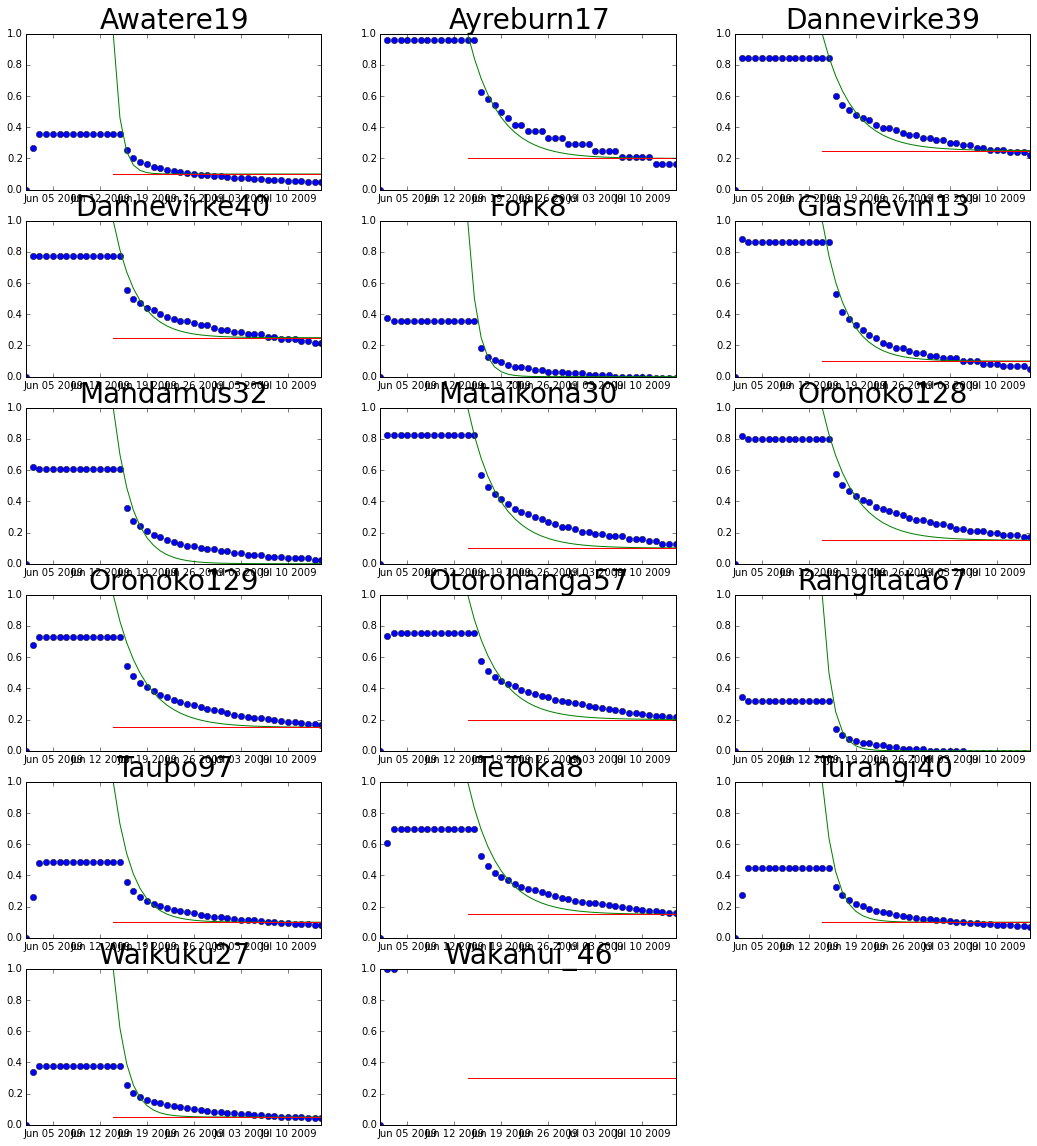

In [75]:
Fig = plt.figure(figsize=(18, 100))

def MakePlot(Position, Soil, swcon, ConLim):
        Fig.add_subplot(30,3,Position)
        plt.title(Soil, fontsize=28)
        plt.plot(FMWC.ix['2009-06-1':'2009-07-15',Soil].index,
                 FMWC.ix['2009-06-1':'2009-07-15',Soil],
                 'o')
        x = FMWC.ix['2009-06-14':'2009-07-15'].index
        y = []
        b = []
        y.append(1)
        b.append(ConLim)
        for z in range(FMWC.ix['2009-06-14':'2009-07-15'].index.size-1):
            y.append(y[z] - (y[z]-ConLim)*swcon) 
            b.append(ConLim)
        plt.plot(x,y)
        plt.plot(x,b)
        plt.ylim(0,1)

swcon = [0.6,0.2,0.2,0.25,0.5,0.25,0.3,0.2,0.2,0.2,0.2,0.5,0.3,0.2,0.4,0.4,0.0]
ConLim = [0.1,0.2,0.25,0.25,0.0,0.1,0,0.1,0.15,0.15,0.2,0,0.1,0.15,0.1,0.05,0.3]
Position = 1
for Soil in Soils:
    MakePlot(Position, Soil, swcon[Position-1], ConLim[Position-1])
    Position +=1

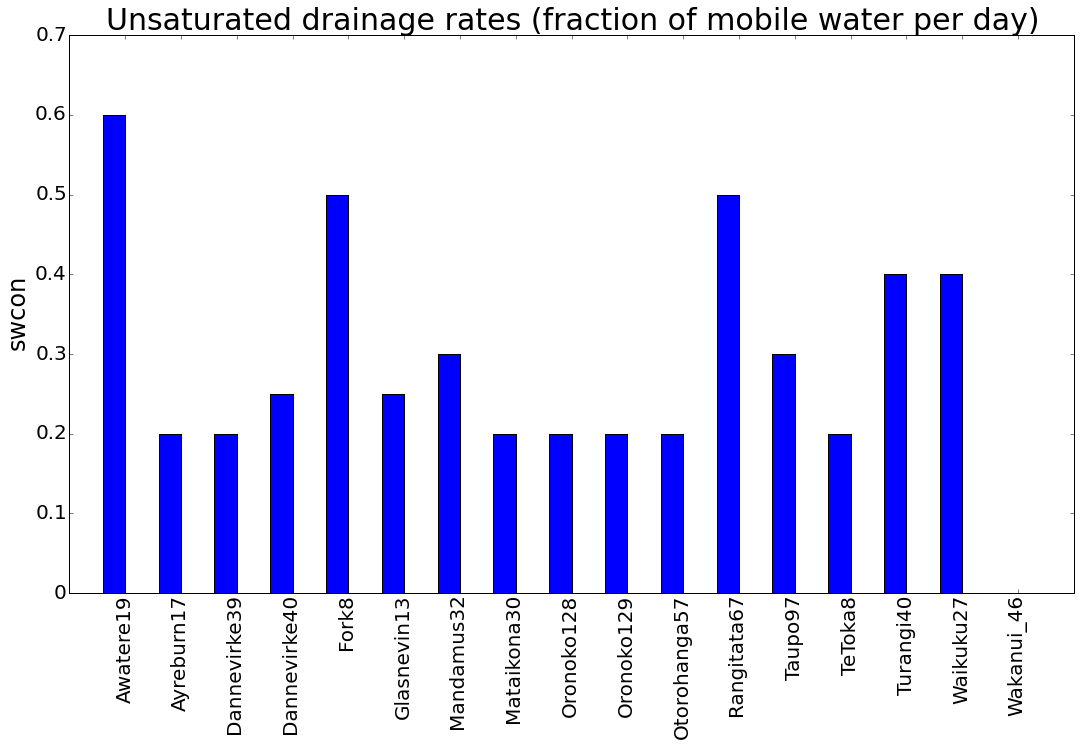

In [76]:
width = 0.4
ind = np.arange(17) - width
fig, ax = plt.subplots(figsize = (18,10))
ax.bar(ind,swcon,width)
ax.set_xticks(range(0,17))
ax.set_xticklabels(Soils, rotation = 90, fontsize=20)
ax.set_xlim(-1,17)
ax.set_ylim(0,0.7)
ax.set_ylabel('swcon', fontsize=24)
ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=20)
ax.set_title('Unsaturated drainage rates (fraction of mobile water per day)', fontsize = 30)

(0, 0.7)

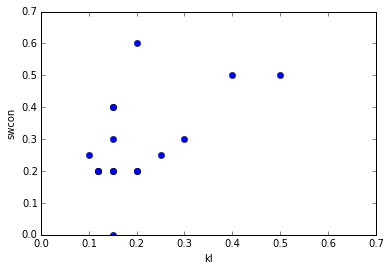

In [82]:
plt.plot(kl,swcon,'o')
plt.xlabel('kl')
plt.ylabel('swcon')
plt.xlim(0,0.7)
plt.ylim(0,0.7)